In [1]:
import os
import numpy as np
from dataset import ClusterEvalDataset, ClusterTestDataset
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import torch
from model import MyModel
from torch.utils.data import DataLoader
from torchvision import transforms
from efficientnet_pytorch import EfficientNet
import torch

In [ ]:
normal_idx = np.flatnonzero(np_label == 2)
incorrect_idx = np.flatnonzero(np_label == 1)

In [2]:
device='cuda'
model = MyModel('efficientnet-b0').to(device)
model.load_state_dict(torch.load('/opt/ml/code/save/cluster/log9_3.pt'))
model.eval()
print('model ready')

Loaded pretrained weights for efficientnet-b0
model ready


In [ ]:
df_test_normal = df_test.iloc[normal_idx]
df_test_incorrect = df_test.iloc[incorrect_idx]

In [3]:
df_test = pd.read_csv('/opt/ml/input/data/eval/info.csv')
df_key = pd.read_csv('/opt/ml/code/df/df_ff.csv')
# df_key1 = pd.read_csv('/opt/ml/code/df/df_actual_age_train.csv')
# df_key2 = pd.read_csv('/opt/ml/code/df/df_actual_age_valid.csv')
#df_valid = pd.read_csv('/opt/ml/code/df/df_valid_cluster.csv')

In [74]:
df_key = pd.concat([df_key1, df_key2])

In [28]:
bins = [0, 29, 59, 100]
labels = [0, 1, 2]
df_key['age_cat'] = pd.cut(df_key['age'], bins=bins, labels=labels)

In [25]:
df_key['age_cat'] = pd.cut(df_key['age'], bins=bins, labels=labels)

In [5]:
transform = transforms.Compose([
                transforms.CenterCrop(350),
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
normal_dataset = ClusterEvalDataset(df_test_normal, transform)
incorrect_dataset = ClusterEvalDataset(df_test_incorrect, transform)
dataloader_normal = DataLoader(normal_dataset, batch_size=64, shuffle=False, num_workers=2)
dataloader_incorrect = DataLoader(incorrect_dataset, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
mtx = model.create_mtx(dataloader, device)

In [ ]:
mtx_ = mtx.copy()

In [ ]:
ind = np.unravel_index(np.argsort(mtx_, axis=None), mtx_.shape)
print(ind)

In [ ]:
ind_x, ind_y = ind
ind_x, ind_y = ind_x[::2], ind_y[::2]

In [ ]:
i = 0

In [ ]:
print(len(ind_x))

In [ ]:
while ind_x[i] == ind_y[i]:
    i += 1

img_idx1 = normal_idx[ind_x[i]]
img_idx2 = normal_idx[ind_y[i]]

# while img_idx1 != 7958 and img_idx2 != 7958:
#     i += 1
#     img_idx1 = normal_idx[ind_x[i]]
#     img_idx2 = normal_idx[ind_y[i]]
# print(i)


fig, axes = plt.subplots(3, 2, figsize=(5, 10))

for rows in axes:
    img_idx1 = normal_idx[ind_x[i]]
    img_idx2 = normal_idx[ind_y[i]]
    for ax, img_idx in zip(rows, [img_idx1, img_idx2]):
        img = Image.open(os.path.join('/opt/ml/input/data/eval/images', df_test.iloc[img_idx]['ImageID']))
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'{img_idx}')
    i += 1
plt.show()

In [ ]:
mtx_ = mtx.copy()

In [ ]:
groups_idx = mtx_.argsort(axis=1)[:,:7]
mtx_.sort(axis=1)
groups_dst = mtx_[:,:7]
len(groups_dst)

In [ ]:
i = 0

In [ ]:
fig, axes = plt.subplots(3, 8, figsize=(15, 7))
fig.suptitle(f'{i+3}/{len(df_test_normal)}')
for row in axes:
    img = Image.open(os.path.join('/opt/ml/input/data/eval/images', df_test_normal.iloc[i]['ImageID']))
    row[0].imshow(img)
    for ax, idx, dst in zip(row[1:], groups_idx[i], groups_dst[i]):
        img = Image.open(os.path.join('/opt/ml/input/data/eval/images', df_test_incorrect.iloc[idx]['ImageID']))
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f'{idx}')
    i += 1
plt.show()

1356, 1535

In [ ]:
# fig, axes = plt.subplots(1, n + 1, figsize=(15, 5))
# axes[0].imshow(img_pil)
# axes[0].axis('off')
# axes[0].set_title('query')

# for ax, i in zip(axes[1:], groups_idx):
#     img = Image.open(df_key.iloc[i]['path'])
#     ax.imshow(img)
#     ax.axis('off')
#     ax.set_title(df_key.iloc[i]['gender'])

# plt.show()

In [6]:
ds_key = ClusterTestDataset(df_key, transform)
ds_test = ClusterEvalDataset(df_test, transform)

dataloader_key = DataLoader(ds_key, batch_size=64, shuffle=False, num_workers=2)
dataloader_query = DataLoader(ds_test, batch_size=64, shuffle=False, num_workers=2)

In [7]:
model.create_keys(dataloader_query, device)

100%|██████████| 197/197 [00:37<00:00,  5.23it/s]


In [11]:
from tqdm import tqdm

model.eval()
n_neighbors = 10

similarities = []

for inputs in tqdm(dataloader_query):
    inputs = inputs.to(device)
    with torch.no_grad():
        queries = model.eff(inputs).cpu().numpy()
    groups_idx = model.query(queries, n_neighbors)
    similarities.append(groups_idx)

100%|██████████| 197/197 [03:05<00:00,  1.06it/s]


In [8]:
similarities[0].shape

(64, 10)

In [32]:
sim_idxs = np.concatenate(similarities)
sim_idxs.shape

(12600, 10)

In [29]:
age_sim = [[df_key.iloc[i]['age'] for i in idxs] for idxs in sim_idxs]

IndexError: single positional indexer is out-of-bounds

In [19]:
sim_idxs[0]

array([    0,  8160,  2769,  6160,  8223,    80,  4053, 11983,  6684,
       12327])

In [15]:
age_sim = np.array(age_sim)

In [16]:
age_voted = [np.bincount(row).argmax() for row in age_sim[:,:5]]

In [17]:
np.bincount(age_voted)

array([4123, 6332, 2145])

In [40]:
i = -1

3


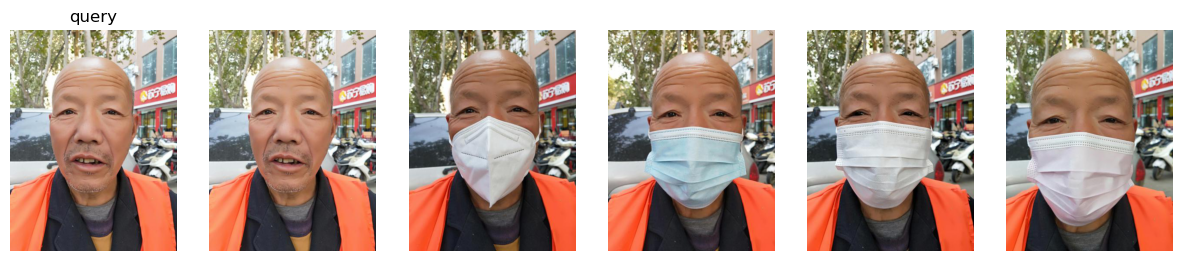

In [44]:
i += 1

img_pil = Image.open(os.path.join('/opt/ml/input/data/eval/images', df_test.iloc[i]['ImageID']))

fig, axes = plt.subplots(1, 5 + 1, figsize=(15, 5))
axes[0].imshow(img_pil)
axes[0].axis('off')
axes[0].set_title('query')

print(i)
for ax, idx in zip(axes[1:], sim_idxs[i]):
    img = Image.open('/opt/ml/input/data/eval/images/' + df_test.iloc[idx]['ImageID'])
    ax.imshow(img)
    ax.axis('off')

plt.show()

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm
n_neighbors = 1
y_pred = []
y_true = []

for i in tqdm(range(len(df_valid))):
    img_pil = Image.open(df_valid.iloc[i]['path'])
    y_true.append(df_valid.iloc[i]['age'])
    a = [0, 0, 0]
    img = transform(img_pil).unsqueeze(0).to(device)
    with torch.no_grad():
        queries = model.eff(img).cpu().numpy()
    groups_idx = model.query(queries, n_neighbors)[0]
    for idx in groups_idx:
        a[df_key.iloc[idx]['age']] += 1
    if a[0] >= a[1]:
        y_pred.append(0)
    else:
        y_pred.append(1)

f1 = f1_score(y_true, y_pred, average='macro')
acc = accuracy_score(y_true, y_pred)
# fig, axes = plt.subplots(1, n + 1, figsize=(15, 5))
# axes[0].imshow(img_pil)
# axes[0].axis('off')
# axes[0].set_title('query')

# for ax, i in zip(axes[1:], groups_idx):
#     img = Image.open(df_key.iloc[i]['path'])
#     ax.imshow(img)
#     ax.axis('off')
#     ax.set_title(df_key.iloc[i]['gender'])

# plt.show()

In [ ]:
print(f1, acc)

In [ ]:
distance_matrix(query, keys)

In [ ]:
i = -1

In [ ]:
df_test = pd.read_csv('/opt/ml/input/data/eval/info.csv')
img_path = '/opt/ml/input/data/eval/images'

In [ ]:
i += 1
fig, axes = plt.subplots(1, 7, figsize=(15, 5))
for ax, idx, dst in zip(axes, groups_idx[i], groups_dst[i]):
    img = Image.open(df_valid.iloc[idx]['path'])
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(df_valid.iloc[idx]['age'])

plt.show()

## Gender Search

In [ ]:
import pickle
with open('gender_pred.pkl', 'rb') as f:
    gender_pred = pickle.load(f)

In [ ]:
df_train = pd.read_csv('/opt/ml/code/df/df_age_train_20.csv')
df_valid = pd.read_csv('/opt/ml/code/df/df_age_valid_20.csv')

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
transform = transforms.Compose([
                transforms.CenterCrop(350),
                transforms.Resize(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [ ]:
class MaskTrainDataset(Dataset):

    def __init__(self, df, transform=None, target='label'):
        self.df = df
        self.transform = transform
        self.target = target
        self.classes = sorted(df[target].unique())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        image_path = self.df['path'].iloc[index]
        image = Image.open(image_path)
        if self.transform is not None:
            image = self.transform(image)
        return image


In [ ]:
df_valid

In [ ]:
ds_valid = MaskTrainDataset(df_valid, transform, target='age')
ds_train = MaskTrainDataset(df_train, transform, target='age')

In [ ]:
dataloader_valid = DataLoader(ds_valid, batch_size=64, shuffle=False, num_workers=2)
dataloader_train = DataLoader(ds_train, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
model.create_keys(dataloader_train, device)

In [ ]:
len(df_valid)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm

n_neighbors = 3
y_pred = []
y_true = []

for i in tqdm(range(len(df_valid))):
    y_true.append(df_valid.iloc[i]['age'])
    img_pil = Image.open(df_valid.iloc[i]['path'])
    a = [0, 0, 0]
    #a[gender_pred['y_pred'][i]] += 2
    img = transform(img_pil).unsqueeze(0).to(device)
    with torch.no_grad():
        queries = model.eff(img).cpu().numpy()
    groups_idx = model.query(queries, n_neighbors)[0]
    for idx in groups_idx:
        # a[gender_pred['y_pred'][idx]] += 1
        a[df_train.iloc[idx]['age']] += 1
    
    y_pred.append(np.argmax(a))
#     if a[0] >= a[1]:
#         y_pred.append(0)
#     else:
#         y_pred.append(1)

f1 = f1_score(y_true, y_pred, average='macro')
acc = accuracy_score(y_true, y_pred)
# fig, axes = plt.subplots(1, n + 1, figsize=(15, 5))
# axes[0].imshow(img_pil)
# axes[0].axis('off')
# axes[0].set_title('query')

# for ax, i in zip(axes[1:], groups_idx):
#     img = Image.open(df_key.iloc[i]['path'])
#     ax.imshow(img)
#     ax.axis('off')
#     ax.set_title(df_key.iloc[i]['gender'])

# plt.show()

In [ ]:
print(acc, f1)

In [ ]:

5 9947